## Step 1. Import Library

In [1]:
from datasets import load_dataset

## Step 2. Load Dataset

In [2]:
dataset = load_dataset("json", data_files="./image_gt.json", split="train[:5%]")#
datasets = dataset.train_test_split(test_size=0.1)
datasets

DatasetDict({
    train: Dataset({
        features: ['image1', 'image2', 'class'],
        num_rows: 201
    })
    test: Dataset({
        features: ['image1', 'image2', 'class'],
        num_rows: 23
    })
})

In [3]:
train_ds = datasets["train"]
test_ds = datasets["test"]
train_ds

Dataset({
    features: ['image1', 'image2', 'class'],
    num_rows: 201
})

['heatmapOn_trajOn_Pair-12-A-Single-EYE_trial07_player.png', 'heatmapOn_trajOn_Pair-12-Comp-EYE_trial14_playerA.png', 'heatmapOn_trajOn_Pair-12-A-Single-EYE_trial37_player.png', 'heatmapOn_trajOn_Pair-12-Comp-EYE_trial22_playerA.png', 'heatmapOn_trajOn_Pair-12-A-Single-EYE_trial09_player.png']
['heatmapOn_trajOn_Pair-12-A-Single-EYE_trial07_observer.png', 'heatmapOn_trajOn_Pair-12-Comp-EYE_trial14_playerB.png', 'heatmapOn_trajOn_Pair-12-A-Single-EYE_trial37_observer.png', 'heatmapOn_trajOn_Pair-12-Comp-EYE_trial22_playerB.png', 'heatmapOn_trajOn_Pair-12-A-Single-EYE_trial09_observer.png']


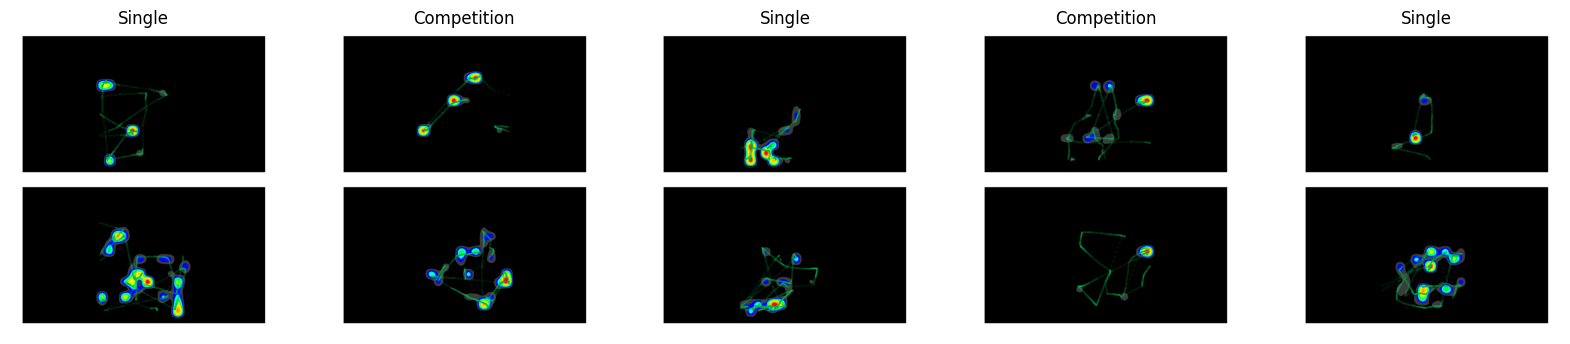

In [4]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def plot_images(images1, images2, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images1)):
        img_path = "./heatmapOn_trajOn/" + images1[i]
        image1 = Image.open(img_path)
        img_path = "./heatmapOn_trajOn/" + images2[i]
        image2 = Image.open(img_path)
        
        image2 = image2.resize((image1.width, image1.height))
        # 創建拼接後的新圖片（寬度為兩張圖片寬度之和）
        new_width = image1.width
        new_height = image1.height + image2.height
        concatenated_image = Image.new('RGB', (new_width, new_height))
        
        # 將圖片粘貼到新圖片上
        concatenated_image.paste(image1, (0, 0))
        concatenated_image.paste(image2, (0, image1.height))

        ax = plt.subplot(1, len(images1), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(concatenated_image)
        plt.axis("off")


sample_images1_to_visualize = [train_ds[i]["image1"] for i in range(5)]
sample_images2_to_visualize = [train_ds[i]["image2"] for i in range(5)]
print(sample_images1_to_visualize)
print(sample_images2_to_visualize)
sample_captions = [train_ds[i]["class"] for i in range(5)]
plot_images(sample_images1_to_visualize, sample_images2_to_visualize, sample_captions)

## Step 3. Preprocess Data 

In [5]:
from PIL import Image
from transformers import AutoProcessor, AutoModel

#processor = AutoProcessor.from_pretrained("microsoft/git-base")
processor = AutoProcessor.from_pretrained("microsoft/git-base-vatex")
#processor = GitProcessor.from_pretrained("microsoft/git-base")


def transforms(example_batch):
    root = "./heatmapOn_trajOn/"
    
    concatenated_images = []
    print(example_batch["image1"])
    # 拼接兩張圖片
    for img_path1, img_path2 in zip(example_batch["image1"], example_batch["image2"]):
        try:
            image1 = Image.open(root + img_path1)
            image2 = Image.open(root + img_path2)
            # 確保兩張圖片的尺寸相同（可選）
            image2 = image2.resize((image1.width, image1.height))
        except Exception as e:
            print(f"Error loading images {img_path1} and {img_path2}: {e}")
            continue


        concatenated_images.append([image1, image2])
        #concatenated_images.append(image1)
        
    
    # 加載文本標籤
    captions = [x for x in example_batch["class"]]
    
    # 將拼接後的圖片和標籤進行處理
    inputs = processor(images=concatenated_images, text=captions, return_tensors="pt", padding="max_length", max_length=32, truncation=True)
    print(f"Pixel values shape: {inputs['pixel_values'].shape}")
    print(f"Input IDs shape: {inputs['input_ids'].shape}")

    inputs.update({"labels": inputs["input_ids"]})
    return inputs



# 設定 transforms 給 train 和 test 資料集
train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

print(train_ds[2])


['heatmapOn_trajOn_Pair-12-A-Single-EYE_trial37_player.png']
Pixel values shape: torch.Size([1, 2, 3, 224, 224])
Input IDs shape: torch.Size([1, 32])
{'input_ids': tensor([ 101, 2309,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'pixel_values': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1.,

In [6]:
from transformers import AutoModelForCausalLM


#model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-vatex")

print(model)


GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

In [7]:
from evaluate import load
import torch

# Load the metrics
accuracy_metric = load("accuracy")
precision_metric = load("precision")
recall_metric = load("recall")
f1_metric = load("f1")



def compute_metrics(eval_pred):
    torch.cuda.empty_cache()
    with torch.no_grad():
        logits, labels = eval_pred
        predicted = logits.argmax(-1)

        decoded_labels = [label.lower() for label in processor.batch_decode(labels, skip_special_tokens=True)]
        decoded_predictions = [pred.lower() for pred in processor.batch_decode(predicted, skip_special_tokens=True)]

        label_mapping = {"cooperation": 0, "single": 1, "competition": 2}
        encoded_labels = [label_mapping.get(label, 4) for label in decoded_labels]
        encoded_predictions = [label_mapping.get(pred, 4) for pred in decoded_predictions]

        # Calculate each metric
        accuracy = accuracy_metric.compute(predictions=encoded_predictions, references=encoded_labels)
        precision = precision_metric.compute(predictions=encoded_predictions, references=encoded_labels, average="weighted")
        recall = recall_metric.compute(predictions=encoded_predictions, references=encoded_labels, average="weighted")
        f1_score = f1_metric.compute(predictions=encoded_predictions, references=encoded_labels, average="weighted")

    torch.cuda.empty_cache()
    return {
        "accuracy": accuracy['accuracy'],
        "precision": precision['precision'],
        "recall": recall['recall'],
        "f1_score": f1_score['f1']
    }


In [11]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir="./vqa_check",
    learning_rate=5e-5,
    num_train_epochs=10,
    fp16=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    eval_accumulation_steps=32,
    save_total_limit=3,
    eval_strategy="steps",
    eval_steps=30,
    save_strategy="steps",
    save_steps=30,
    logging_steps=10,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    report_to="none"
)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [13]:
trainer.train()


  0%|          | 0/30 [00:00<?, ?it/s]

['heatmapOn_trajOn_Pair-13-B-Single-EYE_trial07_player.png', 'heatmapOn_trajOn_Pair-12-Comp-EYE_trial19_playerA.png', 'heatmapOn_trajOn_Pair-12-A-Single-EYE_trial27_player.png', 'heatmapOn_trajOn_Pair-12-A-Single-EYE_trial03_player.png', 'heatmapOn_trajOn_Pair-12-B-Single-EYE_trial33_player.png', 'heatmapOn_trajOn_Pair-12-Coop-EYE_trial02_playerA.png', 'heatmapOn_trajOn_Pair-12-A-Single-EYE_trial38_player.png', 'heatmapOn_trajOn_Pair-12-Comp-EYE_trial14_playerA.png', 'heatmapOn_trajOn_Pair-12-Comp-EYE_trial01_playerA.png', 'heatmapOn_trajOn_Pair-12-B-Single-EYE_trial36_player.png', 'heatmapOn_trajOn_Pair-13-B-Single-EYE_trial04_player.png', 'heatmapOn_trajOn_Pair-12-Comp-EYE_trial40_playerA.png', 'heatmapOn_trajOn_Pair-13-B-Single-EYE_trial11_player.png', 'heatmapOn_trajOn_Pair-12-Coop-EYE_trial28_playerA.png', 'heatmapOn_trajOn_Pair-12-Comp-EYE_trial35_playerA.png', 'heatmapOn_trajOn_Pair-12-Comp-EYE_trial02_playerA.png']
Pixel values shape: torch.Size([16, 2, 3, 224, 224])
Input IDs 

  0%|          | 0/23 [00:00<?, ?it/s]

['heatmapOn_trajOn_Pair-13-B-Single-EYE_trial14_player.png']
Pixel values shape: torch.Size([1, 2, 3, 224, 224])
Input IDs shape: torch.Size([1, 32])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 426, 30522])
Labels shape: torch.Size([1, 32])
num_image_tokens: 1182
hiiiiiiiiiiiiiiii2 Shifted logits shape: torch.Size([1, 31, 30522])
Labels shape: torch.Size([1, 31])
['heatmapOn_trajOn_Pair-12-Coop-EYE_trial14_playerA.png']
Pixel values shape: torch.Size([1, 2, 3, 224, 224])
Input IDs shape: torch.Size([1, 32])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 426, 30522])
Labels shape: torch.Size([1, 32])
num_image_tokens: 1182
hiiiiiiiiiiiiiiii2 Shifted logits shape: torch.Size([1, 31, 30522])
Labels shape: torch.Size([1, 31])
['heatmapOn_trajOn_Pair-12-A-Single-EYE_trial04_player.png']
Pixel values shape: torch.Size([1, 2, 3, 224, 224])
Input IDs shape: torch.Size([1, 32])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 426, 30522])
Labels shape: torch.Size([1, 32

/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 5.83958625793457, 'eval_accuracy': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1_score': 0.0, 'eval_runtime': 2.0904, 'eval_samples_per_second': 11.002, 'eval_steps_per_second': 11.002, 'epoch': 9.23}
{'train_runtime': 122.3391, 'train_samples_per_second': 16.43, 'train_steps_per_second': 0.245, 'train_loss': 6.529112497965495, 'epoch': 9.23}


TrainOutput(global_step=30, training_loss=6.529112497965495, metrics={'train_runtime': 122.3391, 'train_samples_per_second': 16.43, 'train_steps_per_second': 0.245, 'total_flos': 54282059107200.0, 'train_loss': 6.529112497965495, 'epoch': 9.23076923076923})

./heatmapOn_trajOn/heatmapOn_trajOn_Pair-13-A-Single-EYE_trial11_observer.png


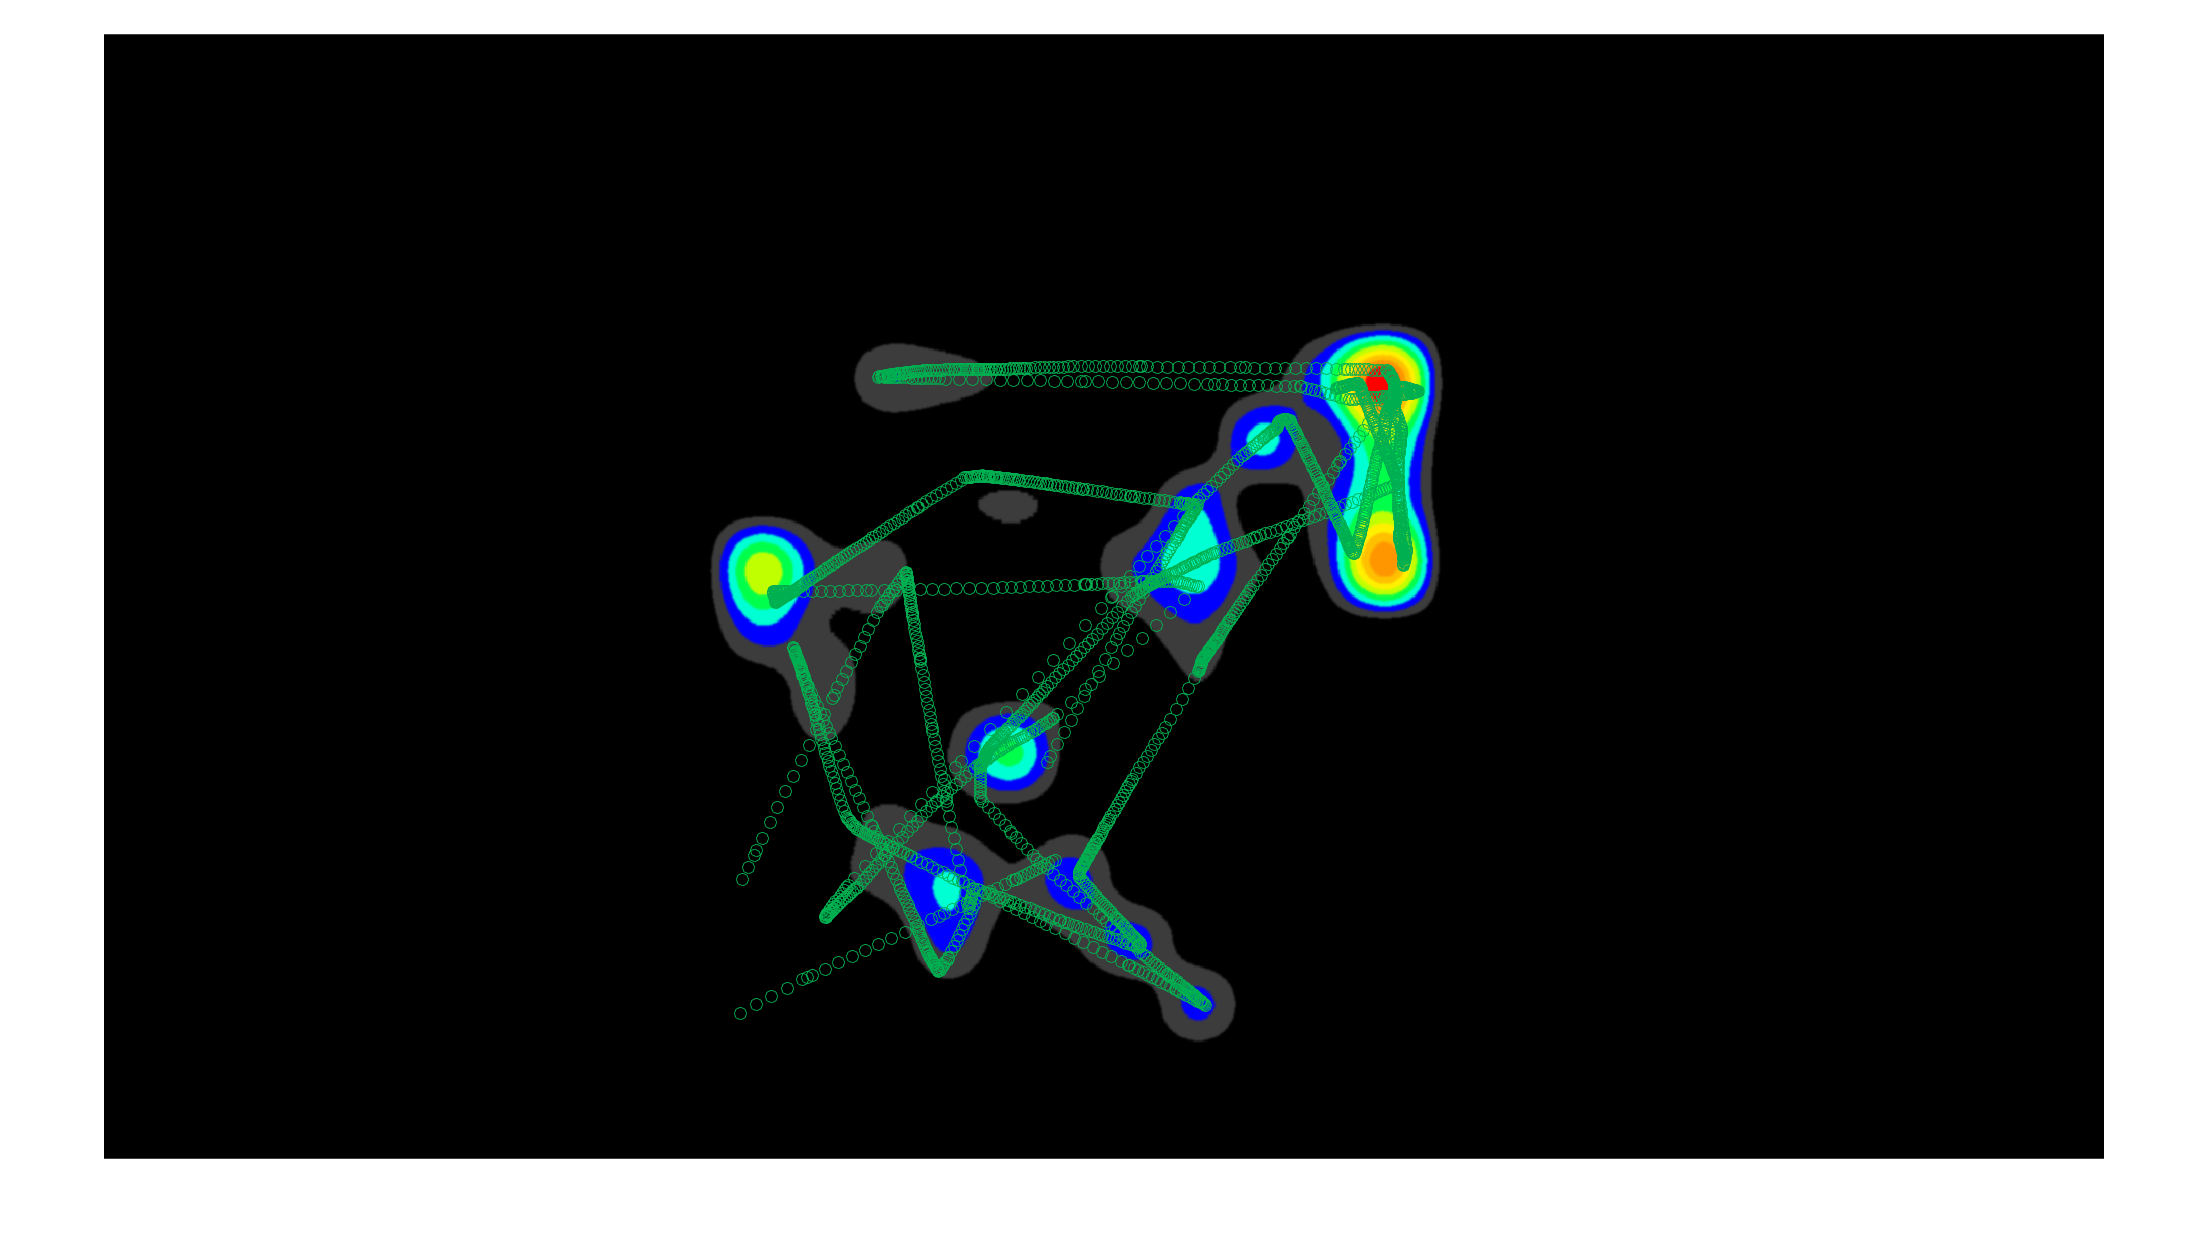

hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 395, 30522])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 396, 30522])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 397, 30522])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 398, 30522])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 399, 30522])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 400, 30522])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 401, 30522])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 402, 30522])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 403, 30522])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 404, 30522])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 405, 30522])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 406, 30522])
hiiiiiiiiiiiiiiii Shifted logits shape: torch.Size([1, 407, 30522])
a computer generated illustration of a fish in a foreign language.


In [2]:
from datasets import load_dataset
from PIL import Image
import torch
from transformers import AutoModelForCausalLM, AutoProcessor


train_ds = load_dataset("json", data_files="./image_gt.json", split="train")#[:5%]

idx = 200
img_path = "./heatmapOn_trajOn/" + train_ds[idx]["image1"]
image1 = Image.open(img_path)
img_path = "./heatmapOn_trajOn/" + train_ds[idx]["image2"]
image2 = Image.open(img_path)
print(img_path)




display(image2)

device = "cpu"#"cuda" if torch.cuda.is_available() else "cpu"

checkpoint = './vqa_check/checkpoint-30/'
processor = AutoProcessor.from_pretrained("microsoft/git-base-vatex")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-vatex")

inputs = processor(images=[image1, image2], return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

In [3]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

./heatmapOn_trajOn/heatmapOn_trajOn_Pair-13-Coop-EYE_trial10_playerB.png


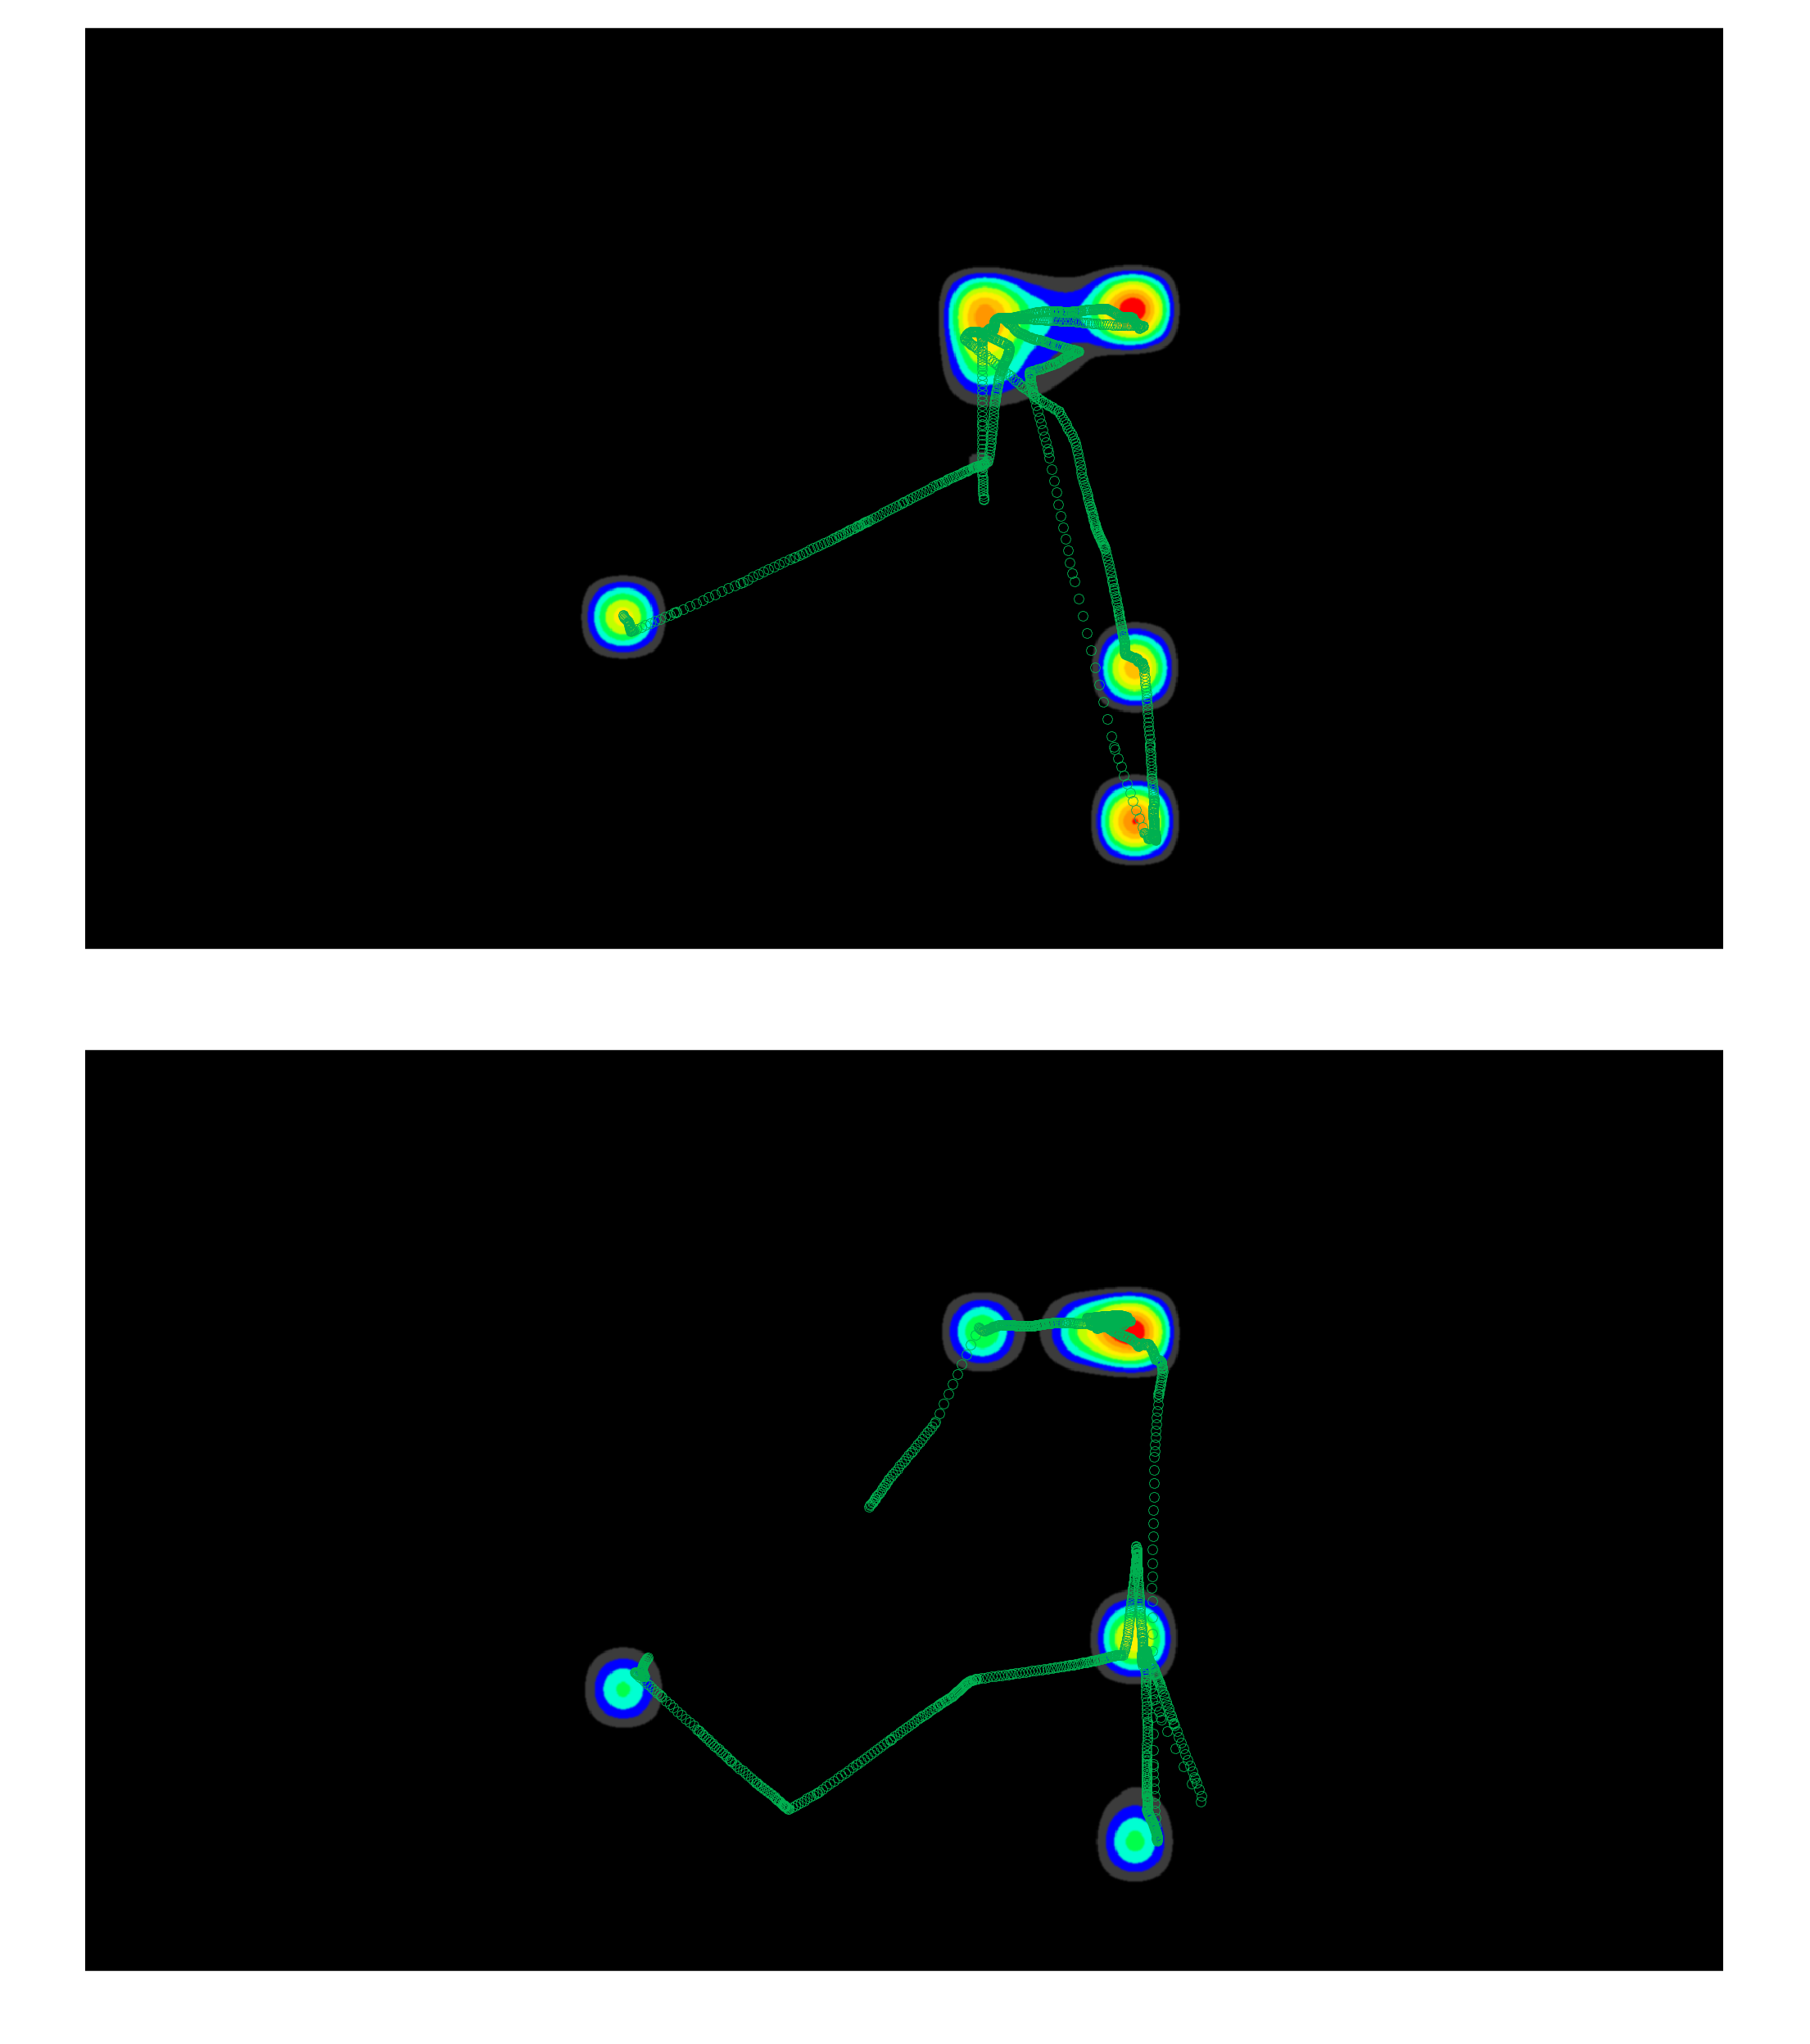

In [9]:
from datasets import load_dataset
from PIL import Image
import torch

train_ds = load_dataset("json", data_files="./image_gt.json", split="train")#[:5%]

idx = 199
img_path = "./heatmapOn_trajOn/" + train_ds[idx]["image1"]
image1 = Image.open(img_path)
img_path = "./heatmapOn_trajOn/" + train_ds[idx]["image2"]
image2 = Image.open(img_path)
print(img_path)

image2 = image2.resize((image1.width, image1.height))
# 創建拼接後的新圖片（寬度為兩張圖片寬度之和）
new_width = image1.width
new_height = image1.height + image2.height
concatenated_image = Image.new('RGB', (new_width, new_height))

# 將圖片粘貼到新圖片上
concatenated_image.paste(image1, (0, 0))
concatenated_image.paste(image2, (0, image1.height))
display(concatenated_image)

In [12]:
question = "This is an eye movement chart. Can you tell if it is single, competition, or coorperative mode?"
prompt = f"Question: {question} Answer:"

inputs = processor(concatenated_image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=10) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Single


In [46]:
from transformers import ViltProcessor, ViltForImagesAndTextClassification
import requests
from PIL import Image
from io import BytesIO

# Load processor and model
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-nlvr2")
model = ViltForImagesAndTextClassification.from_pretrained("dandelin/vilt-b32-finetuned-nlvr2")

# Example batch of image pairs and texts
image_urls = [
    ("https://lil.nlp.cornell.edu/nlvr/exs/ex0_0.jpg", "https://lil.nlp.cornell.edu/nlvr/exs/ex0_1.jpg"),
    ("https://lil.nlp.cornell.edu/nlvr/exs/ex1_0.jpg", "https://lil.nlp.cornell.edu/nlvr/exs/ex1_1.jpg")
]
texts = [
    "The left image contains twice the number of dogs as the right image.",
    "The left image contains three times the number of cats as the right image."
]

# Load images in batch with error handling
images_batch = []
for url1, url2 in image_urls:
    try:
        response1 = requests.get(url1, stream=True)
        response1.raise_for_status()
        image1 = Image.open(BytesIO(response1.content))

        response2 = requests.get(url2, stream=True)
        response2.raise_for_status()
        image2 = Image.open(BytesIO(response2.content))

        images_batch.append([image1, image2])
    except requests.exceptions.RequestException as e:
        print(f"Error retrieving image: {e}")
    except Image.UnidentifiedImageError:
        print("Error: Could not identify image file. Skipping this pair.")

# Ensure we have at least one valid image pair to process
if images_batch:
    # Prepare inputs with the processor
    encoding = processor(images_batch, texts, return_tensors="pt", padding=True)

    # Forward pass in batch
    outputs = model(pixel_values=encoding.pixel_values, input_ids=encoding.input_ids, attention_mask=encoding.attention_mask)
    logits = outputs.logits

    # Print predictions for each image pair
    for i, logit in enumerate(logits):
        idx = logit.argmax(-1).item()
        print(f"Predicted answer for pair {i+1}:", model.config.id2label[idx])
else:
    print("No valid image pairs to process.")


Error retrieving image: 404 Client Error: Not Found for url: https://lil.nlp.cornell.edu/nlvr/exs/ex1_0.jpg


ValueError: Invalid image type. Expected either PIL.Image.Image, numpy.ndarray, torch.Tensor, tf.Tensor or jax.ndarray, but got <class 'list'>.

In [4]:
import numpy as np
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM
from datasets import load_dataset

processor = AutoProcessor.from_pretrained("microsoft/git-base-vatex")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-vatex")

train_ds = load_dataset("json", data_files="./image_gt.json", split="train")#[:5%]

idx = 199
img_path = "./heatmapOn_trajOn/" + train_ds[idx]["image1"]
image1 = Image.open(img_path)
img_path = "./heatmapOn_trajOn/" + train_ds[idx]["image2"]
image2 = Image.open(img_path)
frames = [image1, image2]

pixel_values = processor(images=list(frames), return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)

print("Generated caption:", processor.batch_decode(generated_ids, skip_special_tokens=True))

Generated caption: ['a man is talking about his design.']
